To implement:  
- [x] Galsim shear transormation of an image  
- [ ] Shear transformation given jac matrix in tensorflow
- [ ] Jacobian computation given given shear parameters

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## GalSim transformation

In [2]:
import galsim

In [3]:
gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.2           #
pixel_scale = 0.2  # arcsec / pixel

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=256,ny=256, scale=pixel_scale),
                               x_interpolant='linear')

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal = gal.shear(g1=g1, g2=g2)

In [4]:
image_original = gal.original.drawImage(nx=256,ny=256, scale=pixel_scale, method='no_pixel').array
image_shear = gal.drawImage(nx=256,ny=256,scale=pixel_scale, method='no_pixel').array

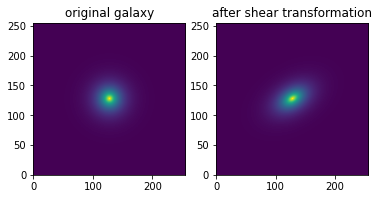

In [5]:
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear transformation')
imshow(image_shear, origin='lower')

## Tensorflow transformation

In [6]:
import tensorflow as tf
import tensorflow_addons as tfa

In [7]:
img = tf.convert_to_tensor(image_original)

In [8]:
# get the jacobian matrix
jac = galsim.Shear(g1=g1, g2=g2).getMatrix()#.ravel().tolist()
jac = tf.cast(np.linalg.inv(jac), float32)

In [9]:
s = img.shape

In [10]:
# Coefficients of the transformation are [a0, a1, a2, b0, b1, b2, c0, c1]
# with (x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k), where k = c0 x + c1 y + 1
transform = tf.convert_to_tensor([jac[0,0], jac[0,1], ((1-jac[0,0]) - jac[0,1])*255/2, 
                                  jac[1,0], jac[1,1], ((1-jac[1,1]) - jac[1,0])*255/2,
                                  0., 0.])
# Because I'm too lazy to workout the coordinate shift corresponding to 
img2 = tfa.image.transform(img, transforms=transform, interpolation='bilinear')

Text(0.5, 1.0, 'after tfa transformation')

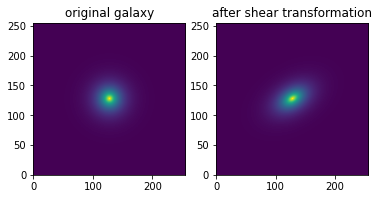

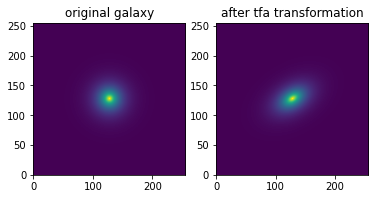

In [11]:
figure()
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear transformation')
imshow(image_shear, origin='lower')

figure()
subplot(121)
imshow(img.numpy(), origin='lower')
title('original galaxy')
subplot(122)
imshow(img2.numpy(), origin='lower')
title('after tfa transformation')

Text(0.5, 1.0, 'Absolute difference')

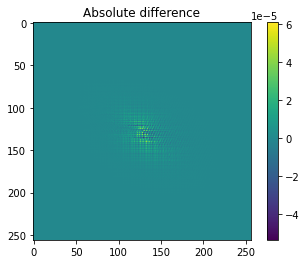

In [12]:
imshow((img2.numpy() - image_shear)); colorbar();
title('Absolute difference')

## Let's try to differentiate the image with respect to shear

In [13]:
@tf.function
def apply_shear(img, g1, g2):
    # Compute the jacobian for some shear (see here https://github.com/GalSim-developers/GalSim/blob/013292ad45b6ef715acf70976e94fe21f624ee4c/galsim/shear.py#L384) 
    jac = tf.convert_to_tensor([[ 1. + g1,    g2   ],
                                [  g2    , 1. - g1 ]]) / tf.sqrt(1.- (g1**2 + g2**2))
    jac = tf.linalg.inv(jac)
    transform = tf.convert_to_tensor([jac[0,0], jac[0,1], ((1-jac[0,0]) - jac[0,1])*255/2, 
                                      jac[1,0], jac[1,1], ((1-jac[1,1]) - jac[1,0])*255/2,
                                      0., 0.])
    return tfa.image.transform(img, transforms=transform, interpolation='bilinear')

In [14]:
img = tf.convert_to_tensor(image_original)
img2 = apply_shear(img, g1, g2)

Text(0.5, 1.0, 'Absolute difference')

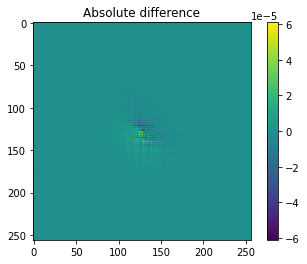

In [15]:
imshow((img2.numpy() - image_shear)); colorbar();
title('Absolute difference')

In [16]:
g1 = tf.convert_to_tensor(g1)
g2 = tf.convert_to_tensor(g2)

with tf.GradientTape() as g:
    g.watch([g1,g2, img])
    img2 = apply_shear(img, g1, g2)
    
res = g.gradient(img2, g1)

In [17]:
res 

In [18]:
# There is no gradient :'-(

## New attempt using TFG

In [19]:
import tensorflow as tf
from tensorflow_graphics.image.transformer import perspective_transform

In [20]:
img = tf.convert_to_tensor(image_original)

In [26]:
@tf.function
def apply_shear2(img, g1, g2):
    # Compute the jacobian for some shear (see here https://github.com/GalSim-developers/GalSim/blob/013292ad45b6ef715acf70976e94fe21f624ee4c/galsim/shear.py#L384) 
    jac = tf.convert_to_tensor([[ 1. + g1,    g2   ],
                                [  g2    , 1. - g1 ]]) / tf.sqrt(1.- (g1**2 + g2**2))
    jac = tf.linalg.inv(jac)
    img = tf.reshape(img, [1,256,256,1])
    transform = tf.convert_to_tensor([[jac[0,0], jac[0,1], ((1-jac[0,0]) - jac[0,1])*256/2], 
                                      [jac[1,0], jac[1,1], ((1-jac[1,1]) - jac[1,0])*256/2],
                                      [0., 0., 1.]])
    transform = tf.reshape(transform, [1,3,3])
    return perspective_transform(img, transform_matrix=transform)

In [27]:
img = tf.convert_to_tensor(image_original)
img3 = apply_shear2(img, g1, g2)

Text(0.5, 1.0, 'Absolute difference')

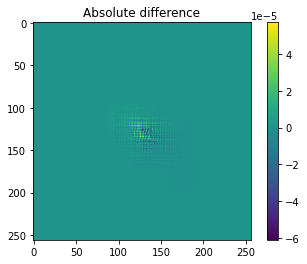

In [28]:
imshow((img3.numpy()[0,:,:,0] - image_shear)); colorbar();
title('Absolute difference')

In [33]:
g1 = tf.convert_to_tensor(g1)
g2 = tf.convert_to_tensor(g2)

with tf.GradientTape() as g:
    g.watch([g1,g2, img])
    img3 = apply_shear2(img, g1, g2)
    loss = tf.reduce_sum((img3[0,:,:,0] - image_shear)**2)
    
res = g.gradient(loss, g1)

In [34]:
res

<tf.Tensor: shape=(), dtype=float32, numpy=0.1067314>

In [ ]:
# It works! We got gradients \o/

## Now, where the fun begins

Let's try to fit the shear applied to the galaxy :-D

In [71]:
shear = tf.Variable(np.zeros(2), trainable=True, name='g', dtype=tf.float32)

In [72]:
# We define our loss function, that depends on shear
@tf.function
def loss(shear, model, obs):
    sheared_model = apply_shear2(model, shear[0], shear[1])
    return tf.reduce_sum((sheared_model[0,:,:,0] - obs)**2)

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
obs = tf.convert_to_tensor(image_shear, dtype=tf.float32)

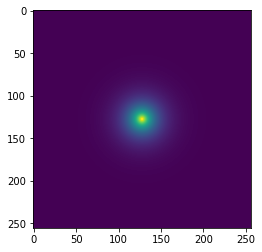

In [74]:
# initial model
imshow(apply_shear2(img, shear[0], shear[1])[0,:,:,0])

In [75]:
# Run optimizer for a little while
for i in range(100):
    optimizer.minimize( lambda : loss(shear, img, obs), [shear])

Text(0.5, 1.0, 'Iter 100')

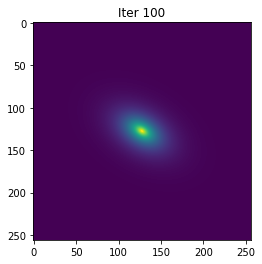

In [78]:
# Fitted model
imshow(apply_shear2(img, shear[0], shear[1])[0,:,:,0])
title('Iter 100')

In [77]:
# measured shear
shear

<tf.Variable 'g:0' shape=(2,) dtype=float32, numpy=array([0.10045818, 0.20022644], dtype=float32)>